In [1]:
import sys
sys.path.append('/project2/alvinjin_1630/results')

from Trainer import Trainer

/project2/alvinjin_1630


In [2]:
import torch, jax
print("PyTorch sees:", torch.cuda.device_count(), "GPUs,", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "none")
print("JAX sees:", jax.devices())

PyTorch sees: 0 GPUs, none
JAX sees: [CpuDevice(id=0)]


In [3]:
trainer = Trainer(
    dataset='MNIST',
    hidden_dims=[512]*8,
    act_fn=jax.nn.relu,
    study_name='512x8_relu',
    num_epochs=50,
    batch_size=64
)

In [4]:
recons = trainer.invert_output(
    target_label=8,
    model_ids=[0],
    num_samples=1,
    steps=1000,
    batch_size=1
)

  0%|          | 0/1 [00:00<?, ?it/s]/home1/adshaw/.local/lib/python3.13/site-packages/equinox/nn/_normalisation.py:92: UserWarning: LayerNorm(elementwise_affine=...) is deprecated in favour of LayerNorm(use_weight=...) and LayerNorm(use_bias=...)
  warnings.warn(


Using mnist


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


In [ ]:
recons[0][0].shape

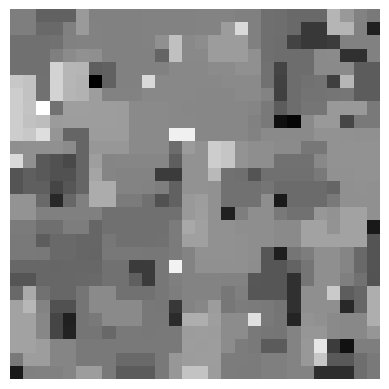

In [5]:
import numpy as np
import matplotlib.pyplot as plt

X = recons[0][0].reshape(28, 28)

plt.imshow(X, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
from Trainer import Model, forward
import numpy as np
import jax.numpy as jnp
import pcx.predictive_coding as pxc
import pcx.utils as pxu

model = Model(
    input_dim=trainer.input_dim,
    output_dim=trainer.output_dim,
    hidden_dims=trainer.hidden_dims,
    act_fn=trainer.act_fn,
    model_key=Trainer.model_keys[0],
    residual=trainer.residual
)
pxu.load_params(model, f'{trainer.root}/{trainer.study_name}/trained_models/model_0')
model.eval()

X = recons[0]
X = np.asarray(X)
if X.ndim == 1:
    X = X[None, :]

import numpy as np
import jax.numpy as jnp
import jax
import pcx.predictive_coding as pxc
import pcx.utils as pxu

target_label = 8

def logits_single(x_vec):
    x_vec = jnp.asarray(x_vec, dtype=jnp.float32)   # shape (784,)
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        return model(x_vec, None)                   # shape (10,)

x0 = X[0]  # (784,)
logits = np.asarray(logits_single(x0))
probs = np.asarray(jax.nn.softmax(jnp.asarray(logits)))

pred = int(probs.argmax())
print("pred:", pred, "p(target):", float(probs[target_label]))
print("probs top3:", probs.argsort()[-3:][::-1], probs[probs.argsort()[-3:][::-1]])


In [ ]:
from Trainer import Model, forward
import numpy as np
import jax.numpy as jnp
import pcx.predictive_coding as pxc
import pcx.utils as pxu

model = Model(
    input_dim=trainer.input_dim,
    output_dim=trainer.output_dim,
    hidden_dims=trainer.hidden_dims,
    act_fn=trainer.act_fn,
    model_key=Trainer.model_keys[0],
    residual=trainer.residual
)
pxu.load_params(model, f'{trainer.root}/{trainer.study_name}/trained_models/model_0')
model.eval()

X = recons[0]
X = np.asarray(X)
if X.ndim == 1:
    X = X[None, :]

# 2) define a pure forward that returns logits
@jax.jit
def logits_fn(x_batch):
    x_batch = jnp.asarray(x_batch, dtype=jnp.float32)
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        # IMPORTANT: y=None => no clamping => returns logits (u)
        return model(x_batch, None)

logits_fn_jit = jax.jit(logits_fn)

preds = []
p8s = []

print("X.shape:", X.shape, "X.dtype:", X.dtype)
print("First row shape:", X[0].shape)
print("model input_dim:", model.input_dim.get())

# 3) run in batches
for start in range(0, len(X), 64):
    xb = X[start:start+64]
    logits = np.asarray(logits_fn_jit(xb))              # (B,10)
    probs = jax.nn.softmax(jnp.asarray(logits), axis=-1)
    probs = np.asarray(probs)

    pred = probs.argmax(axis=-1)
    preds.append(pred)
    p8s.append(probs[:, target_label])

preds = np.concatenate(preds, axis=0)
p8s = np.concatenate(p8s, axis=0)

hit_rate = (preds == target_label).mean()
print(f"Hit rate for label {target_label}: {hit_rate*100:.2f}% "
      f"({(preds==target_label).sum()}/{len(preds)})")
print(f"P(label={target_label})  mean={p8s.mean():.4f}  "
      f"median={np.median(p8s):.4f}  max={p8s.max():.4f}")

print(preds, p8s)